In [84]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import RandomForestRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [85]:
data_dir = os.getenv('HOME')+'/aiffel/exp5/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)

/aiffel/aiffel/exp5/data/train.csv
/aiffel/aiffel/exp5/data/test.csv


In [86]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [87]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

## 데이터 전처리 계획(insight 만을 이용)
1. date -> year, month로 구분
2. zipcode 위도, 경도 전처리 혹은 제거
3. 15년도 이후 데이터를 기준으로 진행. sqft_living과 sqft_lot 데이터 제거
4. 지어진 년도와 재건축 년도를 이용하여 집이 몇년 되었는지 계산하는 변수로 변형

#### 1. date -> year, month, weekday

In [88]:
train['date'] = train['date'].apply(lambda i: i[:8])

In [89]:
train['date'] = pd.to_datetime(train['date'])

In [90]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['weekday'] = train['date'].dt.weekday

In [91]:
train.drop('id', inplace = True, axis = 1)
train.drop('date', inplace = True, axis = 1)

#### 2. zipcode 제거

In [92]:
train.drop('zipcode', inplace = True, axis = 1)

#### 3. 15년 이후 데이터 사용

In [93]:
train.drop('sqft_living', inplace = True, axis = 1)
train.drop('sqft_lot', inplace = True, axis = 1)

#### 4. 재건축에 대한 정보 변경

In [94]:
train['house_year'] = train['yr_renovated']

In [95]:
for i in range(len(train)):
    train['house_year'][i] = 2022 - max(train['yr_renovated'][i], train['yr_built'][i])

In [96]:
train[train['yr_renovated'] != 0][['house_year','yr_built','yr_renovated']]

,house_year,yr_built,yr_renovated
26,20,1930,2002
78,23,1900,1999
149,31,1957,1991
160,44,1915,1978
166,17,1904,2005
...,...,...,...
13626,8,1965,2014
13641,18,1944,2004
13952,16,1977,2006
14218,13,1962,2009


In [97]:
train['renovated'] = train['yr_renovated'] != 0

In [98]:
train.drop('yr_renovated', inplace = True, axis = 1)
train.drop('yr_built', inplace = True, axis = 1)

In [99]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'weekday', 'house_year',
       'renovated'],
      dtype='object')

In [100]:
train.head()

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,year,month,weekday,house_year,renovated
0,221900.0,3,1.00,1.0,0,0,3,7,1180,0,47.5112,-122.257,1340,5650,2014,10,0,67,False
1,180000.0,2,1.00,1.0,0,0,3,6,770,0,47.7379,-122.233,2720,8062,2015,2,2,89,False
2,510000.0,3,2.00,1.0,0,0,3,8,1680,0,47.6168,-122.045,1800,7503,2015,2,2,35,False
3,257500.0,3,2.25,2.0,0,0,3,7,1715,0,47.3097,-122.327,2238,6819,2014,6,4,27,False
4,291850.0,3,1.50,1.0,0,0,3,7,1060,0,47.4095,-122.315,1650,9711,2015,1,3,59,False


#### test 데이터에도 train 데이터와 같은 작업 진행

In [101]:
test['date'] = test['date'].apply(lambda i: i[:8])
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['weekday'] = test['date'].dt.weekday
test.drop('id', inplace = True, axis = 1)
test.drop('date', inplace = True, axis = 1)
test.drop('zipcode', inplace = True, axis = 1)
test.drop('sqft_living', inplace = True, axis = 1)
test.drop('sqft_lot', inplace = True, axis = 1)

In [102]:
test['house_year'] = test['yr_renovated']
for i in range(len(test)):
    test['house_year'][i] = 2022 - max(test['yr_renovated'][i], test['yr_built'][i])
    
test['renovated'] = test['yr_renovated'] != 0
test.drop('yr_renovated', inplace = True, axis = 1)
test.drop('yr_built', inplace = True, axis = 1)

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          15035 non-null  float64
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   floors         15035 non-null  float64
 4   waterfront     15035 non-null  int64  
 5   view           15035 non-null  int64  
 6   condition      15035 non-null  int64  
 7   grade          15035 non-null  int64  
 8   sqft_above     15035 non-null  int64  
 9   sqft_basement  15035 non-null  int64  
 10  lat            15035 non-null  float64
 11  long           15035 non-null  float64
 12  sqft_living15  15035 non-null  int64  
 13  sqft_lot15     15035 non-null  int64  
 14  year           15035 non-null  int64  
 15  month          15035 non-null  int64  
 16  weekday        15035 non-null  int64  
 17  house_year     15035 non-null  int64  
 18  renova

## Data EDA

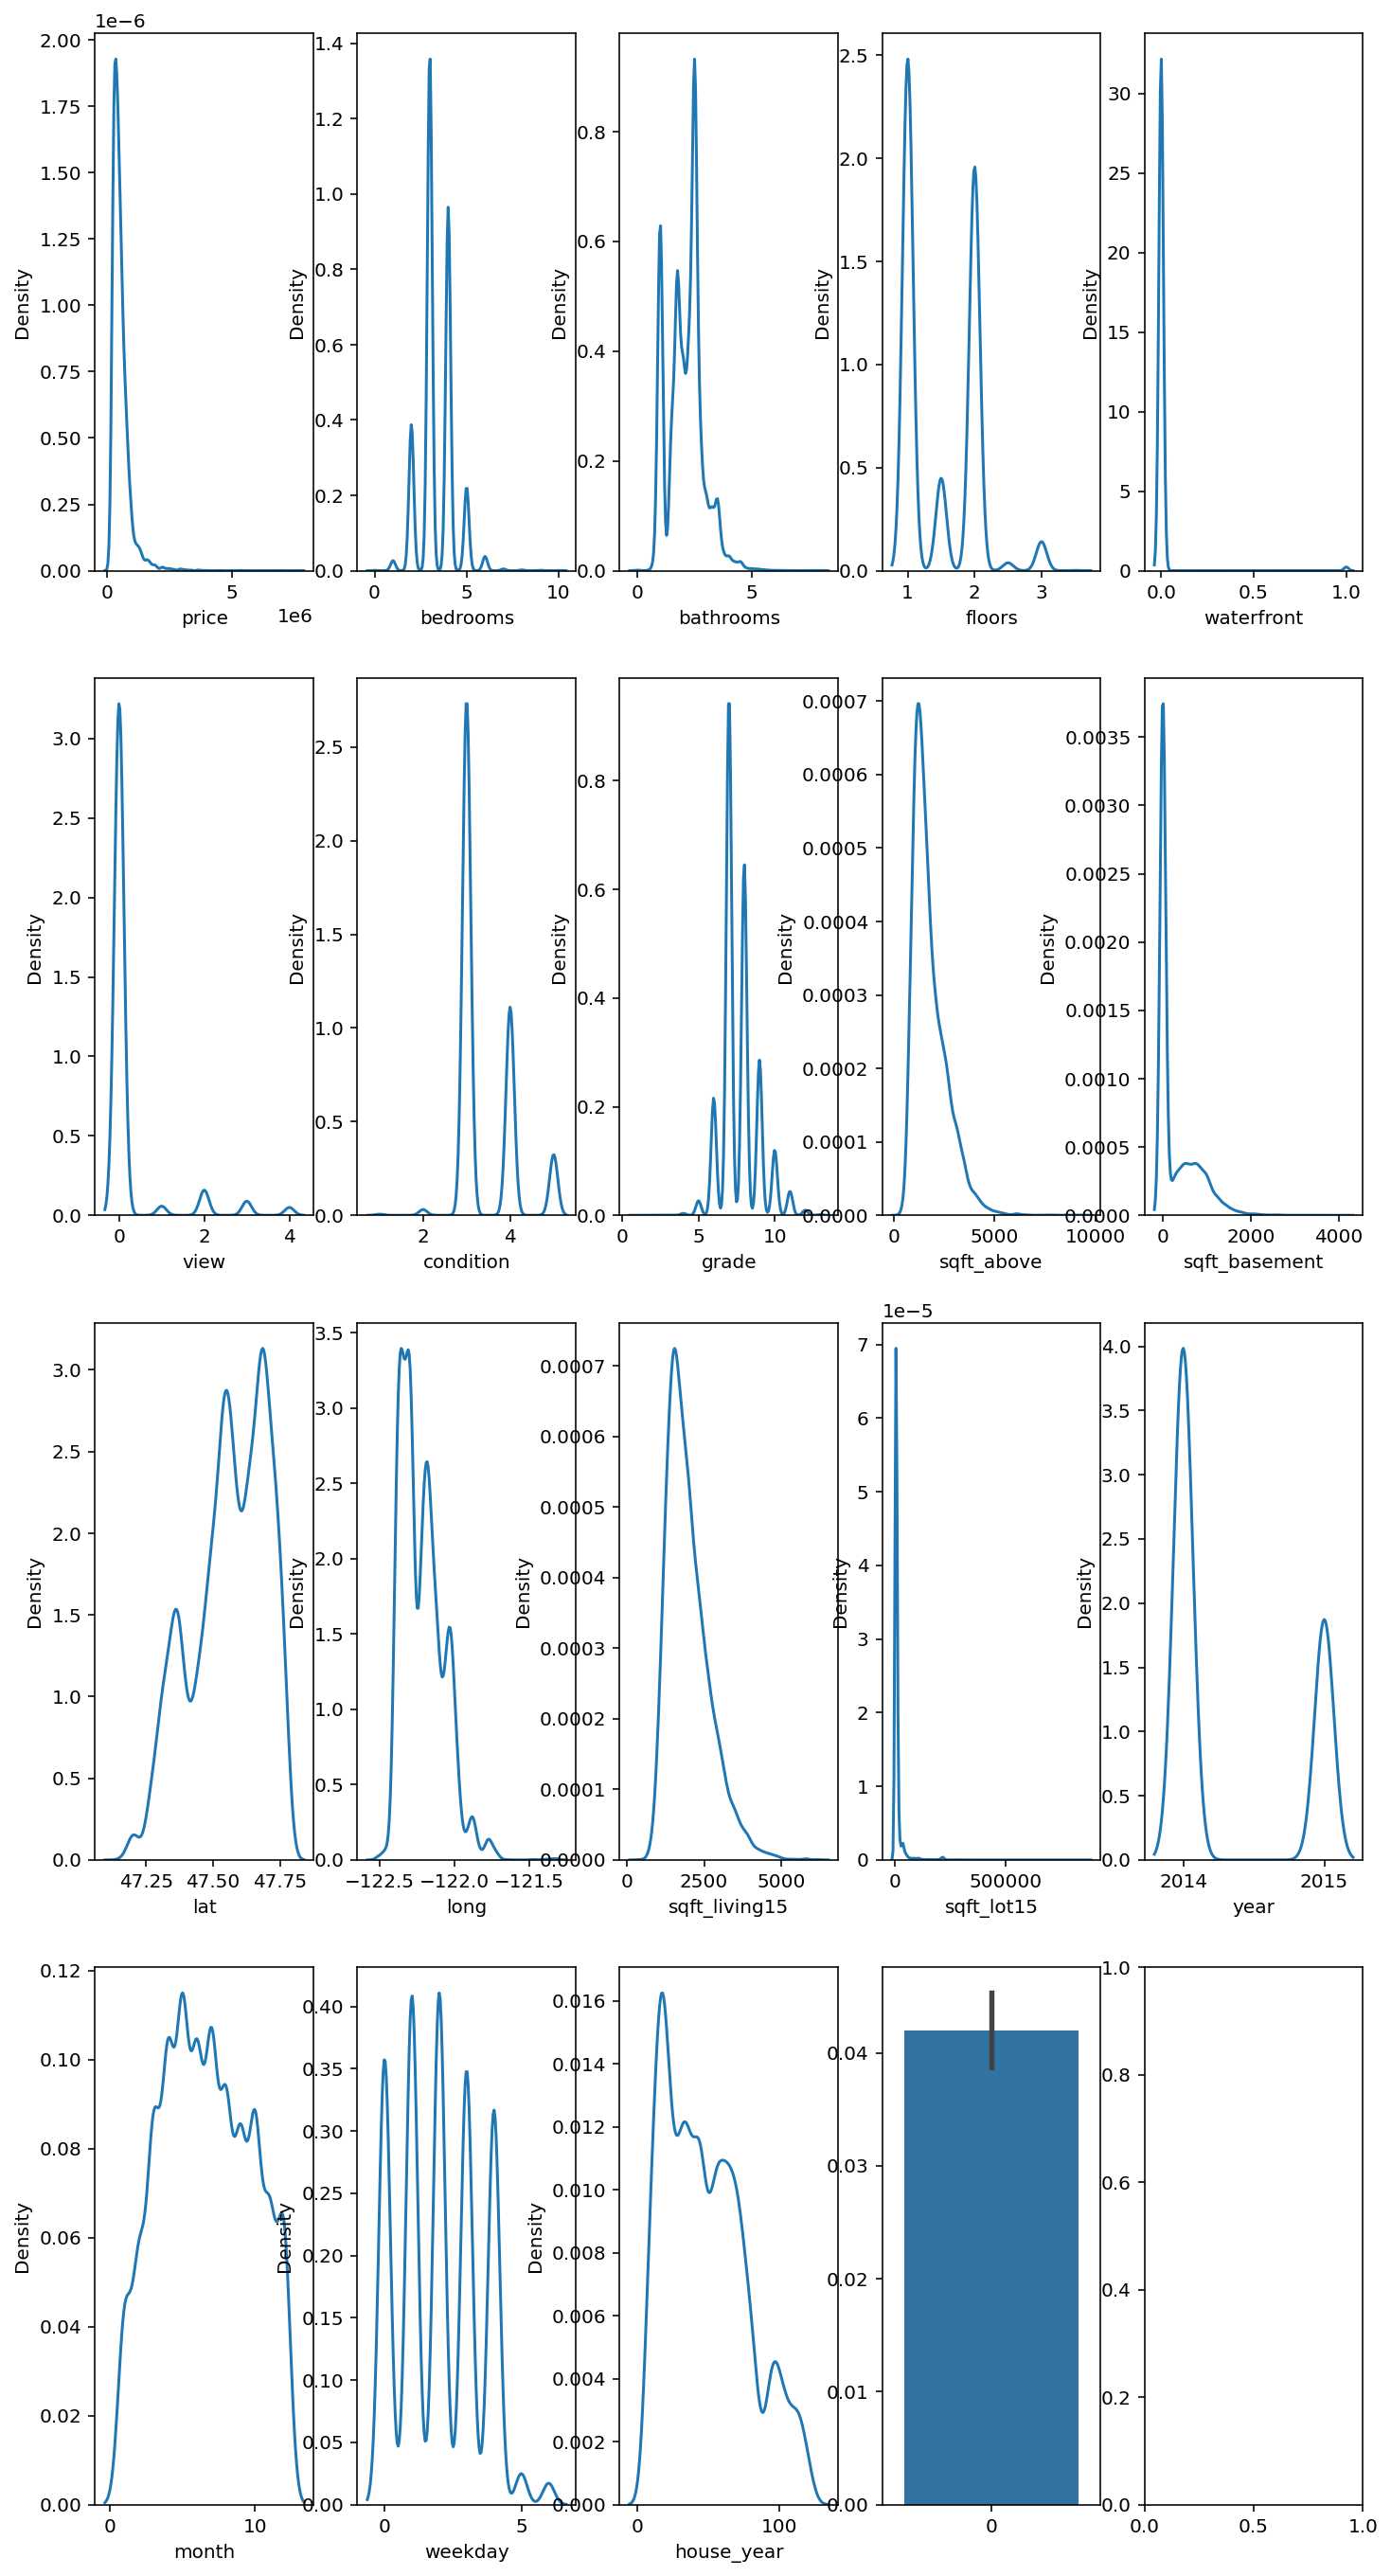

In [22]:
fig, ax = plt.subplots(4, 5, figsize=(12, 24))

for idx, column in enumerate(train.columns):
    try:sns.kdeplot(data=train[column], ax = ax[idx // 5 ][idx % 5 ])
    except: sns.barplot(data = train[column], ax = ax[idx // 5 ][idx % 5 ])

### 연속형 변수와 이산형 변수를 구분

In [23]:
for idx, column in enumerate(train.columns):
    print('{} : '.format(column),train[column].unique())

price :  [ 221900.  180000.  510000. ... 1537000.  610685. 1007500.]
bedrooms :  [ 3  2  5  4  6  1  7  9  8  0 10]
bathrooms :  [1.   2.   2.25 1.5  2.5  1.75 3.   2.75 3.25 4.   3.5  0.75 4.75 5.
 4.25 4.5  3.75 5.25 6.   1.25 0.5  5.5  6.75 5.75 0.   8.   7.5  7.75
 6.25]
floors :  [1.  2.  1.5 3.  2.5 3.5]
waterfront :  [0 1]
view :  [0 3 4 2 1]
condition :  [3 4 5 2 1]
grade :  [ 7  6  8  9 10 11 12  5  4  3 13  1]
sqft_above :  [1180  770 1680 1715 1060 1860  860 1430 1370 1810 1980 1890 1600 1200
 1250 2330 1070 2450 1710 1750 1400 2320 1510 1090 1280 2360  890 2620
 2600 3595 1570  990 2290 1000 2830 2250 2420 3250 1590 1260 1540 1110
 2720 2240 3070 2390  910 3450 2350 1900  960 2660  765 3520 1290 1960
 1160 1270 2190 1210 1240 3140 2310  700 1080 2520 2780  880 1560 1720
 1620 1360 1440 2140 1320 1010 1340 1190 1170  940 3670 3540 2500 1760
 1030 1780 3400 2680 1610 1670 2570 2590  820 1220 2440 1050 2090 1100
 1420 1690 1130 1910 1350 1940  900 1630 1550 2714 1870 1950 2020

#### sqft_above, sqft_basement, sqft_living15, sqft_lot15, lat, long -> LogScaler(데이터의 정규성이 가장 만족하지 않음)

#### 전체에 대해 단위 Scale(변수들의 단위가 너무 달라 이를 맞춰주는 과정)

In [24]:
train

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,year,month,weekday,house_year,renovated
0,221900.0,3,1.00,1.0,0,0,3,7,1180,0,47.5112,-122.257,1340,5650,2014,10,0,67,False
1,180000.0,2,1.00,1.0,0,0,3,6,770,0,47.7379,-122.233,2720,8062,2015,2,2,89,False
2,510000.0,3,2.00,1.0,0,0,3,8,1680,0,47.6168,-122.045,1800,7503,2015,2,2,35,False
3,257500.0,3,2.25,2.0,0,0,3,7,1715,0,47.3097,-122.327,2238,6819,2014,6,4,27,False
4,291850.0,3,1.50,1.0,0,0,3,7,1060,0,47.4095,-122.315,1650,9711,2015,1,3,59,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,610685.0,4,2.50,2.0,0,0,3,9,2520,0,47.5137,-122.167,2520,6023,2014,10,1,8,False
15031,1007500.0,4,3.50,2.0,0,0,3,9,2600,910,47.5537,-122.398,2050,6200,2015,3,3,13,False
15032,360000.0,3,2.50,3.0,0,0,3,8,1530,0,47.6993,-122.346,1530,1509,2014,5,2,13,False
15033,400000.0,4,2.50,2.0,0,0,3,8,2310,0,47.5107,-122.362,1830,7200,2015,2,0,8,False


In [107]:
train['long'] = abs(train['long'])
test['long'] = abs(test['long'])

In [108]:
train[['price','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long']] = np.log1p(train[['price','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long']])
test[['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long']] = np.log1p(test[['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'lat', 'long']])

In [109]:
train

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,year,month,weekday,house_year,renovated
0,12.309987,3,1.00,1.0,0,0,3,7,7.074117,0.000000,3.881795,4.814272,7.201171,8.639588,2014,10,0,67,False
1,12.100718,2,1.00,1.0,0,0,3,6,6.647688,0.000000,3.886457,4.814077,7.908755,8.995041,2015,2,2,89,False
2,13.142168,3,2.00,1.0,0,0,3,8,7.427144,0.000000,3.883969,4.812550,7.496097,8.923191,2015,2,2,35,False
3,12.458779,3,2.25,2.0,0,0,3,7,7.447751,0.000000,3.877632,4.814839,7.713785,8.827615,2014,6,4,27,False
4,12.583999,3,1.50,1.0,0,0,3,7,6.966967,0.000000,3.879696,4.814742,7.409136,9.181118,2015,1,3,59,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,13.322338,4,2.50,2.0,0,0,3,9,7.832411,0.000000,3.881846,4.813541,7.832411,8.703507,2014,10,1,8,False
15031,13.822984,4,3.50,2.0,0,0,3,9,7.863651,6.814543,3.882670,4.815415,7.626083,8.732466,2015,3,3,13,False
15032,12.793862,3,2.50,3.0,0,0,3,8,7.333676,0.000000,3.885665,4.814993,7.333676,7.319865,2014,5,2,13,False
15033,12.899222,4,2.50,2.0,0,0,3,8,7.745436,0.000000,3.881784,4.815123,7.512618,8.881975,2015,2,0,8,False


In [118]:
col = test.columns

In [110]:
X_train = train[train.columns.difference(['price'])]
y_train = train['price']
X_test = test

In [111]:
X_train

,bathrooms,bedrooms,condition,floors,grade,house_year,lat,long,month,renovated,sqft_above,sqft_basement,sqft_living15,sqft_lot15,view,waterfront,weekday,year
0,1.00,3,3,1.0,7,67,3.881795,4.814272,10,False,7.074117,0.000000,7.201171,8.639588,0,0,0,2014
1,1.00,2,3,1.0,6,89,3.886457,4.814077,2,False,6.647688,0.000000,7.908755,8.995041,0,0,2,2015
2,2.00,3,3,1.0,8,35,3.883969,4.812550,2,False,7.427144,0.000000,7.496097,8.923191,0,0,2,2015
3,2.25,3,3,2.0,7,27,3.877632,4.814839,6,False,7.447751,0.000000,7.713785,8.827615,0,0,4,2014
4,1.50,3,3,1.0,7,59,3.879696,4.814742,1,False,6.966967,0.000000,7.409136,9.181118,0,0,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,2.50,4,3,2.0,9,8,3.881846,4.813541,10,False,7.832411,0.000000,7.832411,8.703507,0,0,1,2014
15031,3.50,4,3,2.0,9,13,3.882670,4.815415,3,False,7.863651,6.814543,7.626083,8.732466,0,0,3,2015
15032,2.50,3,3,3.0,8,13,3.885665,4.814993,5,False,7.333676,0.000000,7.333676,7.319865,0,0,2,2014
15033,2.50,4,3,2.0,8,8,3.881784,4.815123,2,False,7.745436,0.000000,7.512618,8.881975,0,0,0,2015


In [112]:
X_test

,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,lat,long,sqft_living15,sqft_lot15,year,month,weekday,house_year,renovated
0,3,2.25,2.0,0,0,3,7,7.682943,5.993961,3.886110,4.814774,7.433075,8.941153,2014,12,1,31,True
1,4,3.00,1.0,0,0,5,7,6.957497,6.814543,3.881993,4.815374,7.215975,8.517393,2014,12,1,57,False
2,4,4.50,1.0,0,0,3,11,8.266421,7.333676,3.884777,4.812225,8.468213,11.532051,2014,5,0,21,False
3,3,1.00,1.0,0,0,3,7,6.957497,6.594413,3.881817,4.814920,7.484930,9.001346,2015,4,2,62,False
4,3,2.50,2.0,0,0,3,7,7.544861,0.000000,3.878847,4.812436,7.779467,8.932080,2015,3,3,19,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,3,1.75,1.0,0,0,3,6,7.313887,0.000000,3.877628,4.812201,7.186144,9.332912,2014,6,3,8,False
6464,3,2.00,3.0,0,0,3,8,7.307202,0.000000,3.883004,4.814523,7.244942,7.115582,2015,1,0,8,False
6465,3,2.50,2.0,0,0,3,8,7.074117,4.875197,3.883156,4.815504,7.193686,7.143618,2015,2,3,14,False
6466,2,0.75,2.0,0,0,3,7,6.928538,0.000000,3.883508,4.814612,6.928538,7.604894,2014,6,0,13,False


In [119]:
X_train = X_train[col]
X_test = X_test[col]

## Modeling

In [34]:
rf = RandomForestRegressor(random_state = 2022)
ada = AdaBoostRegressor(random_state = 2022)
lgb = LGBMRegressor(random_state = 2022)

In [35]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)

    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    df = pd.DataFrame(params)
    df['score'] = grid_model.cv_results_['mean_test_score']
    df['RMSLE'] = np.sqrt(-1 * df['score'])
    return df.sort_values(by = 'RMSLE', ascending = True)

In [133]:
rf_param_grid = {
    'n_estimators' : [100, 200, 500, 1000],
#     'max_depth' : [None, 10, 20, 30, 50],
}

In [134]:
ada_param_grid = {
    'n_estimators':[100, 200, 500, 1000],
    'loss':['linear', 'square', 'exponential'],
    'learning_rate' : [0.001, 0.001, 0.1, 1]    
}

In [137]:
lgb_param_grid = {
#     'max_depth' : [None, 10, 20, 30, 50],
#     'learning_rate' : [0.001, 0.001, 0.1, 1]   ,
    'n_estimators':[100, 200, 500, 1000],
    'num_leaves' : [10, 20, 30],
    'boosting_type' : ['gbdt', 'dart','goss','rf']    
}

### RandomForest

In [138]:
my_GridSearch(rf, X_train, y_train, rf_param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,n_estimators,score,RMSLE
3,1000,-0.032780,0.181052
2,500,-0.032826,0.181180
1,200,-0.032987,0.181624
0,100,-0.033261,0.182377


### AdaBoost

In [139]:
my_GridSearch(ada, X_train, y_train, ada_param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,learning_rate,loss,n_estimators,score,RMSLE
42,1.000,square,500,-0.069748,0.264098
41,1.000,square,200,-0.069895,0.264377
43,1.000,square,1000,-0.070059,0.264686
40,1.000,square,100,-0.070099,0.264762
33,0.100,exponential,200,-0.070545,0.265604
44,1.000,exponential,100,-0.070805,0.266092
34,0.100,exponential,500,-0.071019,0.266495
36,1.000,linear,100,-0.071326,0.267070
25,0.100,linear,200,-0.071778,0.267914
26,0.100,linear,500,-0.071884,0.268113


### LightGBM

In [140]:
my_GridSearch(lgb, X_train, y_train, lgb_param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END ...................................n_estimators=100; total time=  15.1s
[CV] END ...................................n_estimators=200; total time=  41.0s
[CV] END ...................................n_estimators=500; total time= 1.6min
[CV] END ..................................n_estimators=1000; total time= 3.0min
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=  11.8s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=200; total time=  24.8s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=500; total time=  54.8s
[CV] END learning_rate=0.001, loss=linear, n_estimators=1000; total time= 1.9min
[CV] END .learning_rate=0.001, loss=square, n_estimators=100; total time=  10.9s
[CV] END .learning_rate=0.001, loss=square, n_estimators=200; total time=  20.3s
[CV] END .learning_rate=0.001, loss=square, n_estimators=500; total time=  54.8s
[CV] END learning_rate=0.001, loss=square, n_es

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check 

[CV] END ...................................n_estimators=100; total time=  18.5s
[CV] END ...................................n_estimators=200; total time=  33.8s
[CV] END ...................................n_estimators=500; total time= 1.5min
[CV] END ..................................n_estimators=1000; total time= 3.1min
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=  13.1s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=200; total time=  24.3s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=500; total time= 1.0min
[CV] END learning_rate=0.001, loss=linear, n_estimators=1000; total time= 2.0min
[CV] END .learning_rate=0.001, loss=square, n_estimators=200; total time=  23.7s
[CV] END .learning_rate=0.001, loss=square, n_estimators=500; total time=  59.5s
[CV] END learning_rate=0.001, loss=square, n_estimators=1000; total time= 2.2min
[CV] END learning_rate=0.001, loss=exponential, n_estimators=200; total time=  20.4s
[CV] END learning_rate=0

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check failed: config->bagging_freq > 0 && config->bagging_fraction < 1.0f && config->bagging_fraction > 0.0f at /__w/1/s/python-package/compile/src/boosting/rf.hpp, line 35 .

[LightGBM] [Fatal] Check 

[CV] END ...................................n_estimators=100; total time=  16.9s
[CV] END ...................................n_estimators=200; total time=  35.4s
[CV] END ...................................n_estimators=500; total time= 1.4min
[CV] END ..................................n_estimators=1000; total time= 3.1min
[CV] END .learning_rate=0.001, loss=linear, n_estimators=100; total time=   9.2s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=200; total time=  28.9s
[CV] END .learning_rate=0.001, loss=linear, n_estimators=500; total time=  59.0s
[CV] END learning_rate=0.001, loss=linear, n_estimators=1000; total time= 1.9min
[CV] END .learning_rate=0.001, loss=square, n_estimators=100; total time=  10.4s
[CV] END .learning_rate=0.001, loss=square, n_estimators=200; total time=  24.0s
[CV] END .learning_rate=0.001, loss=square, n_estimators=500; total time=  59.1s
[CV] END learning_rate=0.001, loss=square, n_estimators=1000; total time= 1.8min
[CV] END learning_rate=0.001

,boosting_type,n_estimators,num_leaves,score,RMSLE
9,gbdt,1000,10,-0.027386,0.165487
7,gbdt,500,20,-0.027466,0.165729
6,gbdt,500,10,-0.027568,0.166036
5,gbdt,200,30,-0.027575,0.166058
4,gbdt,200,20,-0.027725,0.166509
8,gbdt,500,30,-0.027818,0.166788
30,goss,500,10,-0.027823,0.166803
10,gbdt,1000,20,-0.027951,0.167185
28,goss,200,20,-0.028039,0.167448
29,goss,200,30,-0.028228,0.168013


In [49]:
def save_submission(model, train, y, test, model_name, rmsle):
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/exp5/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)

In [148]:
model = RandomForestRegressor(n_estimators=1000, random_state = 2022)

In [149]:
model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=2022)

In [150]:
save_submission(model, X_train, y_train, X_test, model.__class__.__name__, rmsle='0.181052')

### Score : 138221.98186

In [145]:
model = AdaBoostRegressor(learning_rate= 1.000, loss = 'square', n_estimators=500)

In [146]:
model.fit(X_train, y_train)

AdaBoostRegressor(loss='square', n_estimators=500)

In [147]:
save_submission(model, X_train, y_train, X_test, model.__class__.__name__, rmsle='0.264098')

### Score : 197681.35705

In [142]:
model = LGBMRegressor(boosting_type='gbdt', n_estimators=1000, num_leaves = 10)

In [143]:
model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, num_leaves=10)

In [144]:
save_submission(model, X_train, y_train, X_test, model.__class__.__name__, rmsle='0.165487')

### Score : 109707.31187